# Capstone Project Week5
## Restaurant in Salt Lake City
### Problem Statement
We would like to understand which neighborhoods of Salt Lake City area are better for opening a restaurant and which type of restaurant (Chinese, Japanese, American, etc.) it should be.

### Discussion of Background
The Salt Lake City area is drawing a lot of people moving into the area which gives a profit opportunity of opening a restaurant. We would like to first understand the current status of the neighborhoods so we know which areas have more restaurants already. We would also like to understand if demographic factors such as population, household, income, etc. can explain the difference among neighborhoods. Such understanding may give us insights on which neighborhood we should open the restaurant.

### Data Source
1. Neighborhood data for the Salt Lake City area: data is taken from this website: https://statisticalatlas.com/place/Utah/Salt-Lake-City/Overview
2. Venue data for each neighborhood: data is taken from foursquare using their API.
3. Demographic data for each neighborhood: This data is taken from a series of websites based on the list of neighborhoods and factors that we are interested in. Examples of factors can be: population, number of household, age and sex, race and ethnicity, household type (married or not), income, etc. We will use these neighborhoods and factors to scan through a series of websites. One example is: https://statisticalatlas.com/neighborhood/Utah/Salt-Lake-City/Yalecrest/Race-and-Ethnicity

### Method of Analysis
Step 1: Data retrieval  
1.1 Retrieve the neighborhood list of Salt Lake City area including geospatial coordinates and visualize neighborhoods in map  
1.2 Generate the list of demographic factors we are interested in  
1.3 Extract demographic factors: population, household count, age, etc.  

Step 2: Neighborhood clustering and model building  
2.1 Following similar method for previous assignment: generate the top venue types for each neighborhood.  
2.2 Cluster neighborhood to understand which neighborhood has more restaurants and which type of restaurant is more popular.  
2.3 Examine if demographic factors show significant difference among clusters.  
2.4 Examine if a model can be created to explain the restaurant percentage in each neighborhood. If so, then find which neighborhoods have less restaurant than model predicted. Such neighborhoods can be an opportunity to open new restaurants.

### Code of Analysis
#### First: Import libraries

In [1]:
# import needed libraries
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import numpy as np
import json
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 
import seaborn as sns

from bs4 import BeautifulSoup

from pandas.io.json import json_normalize
from sklearn.cluster import KMeans

!pip install folium==0.5.0 # comment it off after initial run
import folium
!pip install geopy # comment it off after initial run
from geopy.geocoders import Nominatim


print("Import done.")

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 79 kB 8.2 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=de33b579661cae1646c283437a506f61fedff60084ddc45b675bb92b0cd12053
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptog

#### Step 1.1: Retrieve the neighborhood list of Salt Lake City area including geospatial coordinates and visualize neighborhoods in map

In [3]:
# retrieve html from the url containing slc neighborhood
url = 'https://statisticalatlas.com/place/Utah/Salt-Lake-City/Overview' # url of the website containing neighborhoods of SLC
slc_url = requests.get(url).text

In [4]:
# parse data with BeautifulSoup
soup = BeautifulSoup(slc_url,'lxml')
#print(soup.prettify())

In [5]:
# parse out the neighborhood list
soup_tb = soup.find_all("div", class_="info-table")

soup_row = soup_tb[0].find_all("div", class_ = "info-table-tr row")

for row in soup_row:
    if row.find("div", class_ = "b info-table-title-td col-sm-3").text == "Neighborhoods: ":
        soup_neighbor = row.find_all("a")

neighbor_list = []
for row in soup_neighbor:
    neighbor_list.append(row.text)

# output the list of neighborhood
neighbor_list

['Arcadia Heights',
 'Bonneville Hills',
 'Capitol Hill',
 'Central City',
 'Central City-Liberty Wells',
 'Downtown',
 'East Bench',
 'East Central',
 'Fairpark',
 'Glendale',
 'Greater Avenues',
 'Jordan Meadows',
 'Liberty Wells',
 "People's Freeway",
 'Poplar Grove',
 'Rose Park',
 'Sugar House',
 'Wasatch Hollow',
 'Westpointe',
 'Yalecrest']

In [6]:
# retrieve latitude and longitude of each neighborhood
# as I found the geocoder.google takes much effort to enable, the geo coordinates are manually retrieved from google map for each neighborhood
# then the info is stored to a csv file under the github folder
url = "https://raw.githubusercontent.com/kanzhang36/Coursera_Capstone/176a9f155a69037e5d62c9aa1e02ef76384537b7/neighbor_geo.csv"
neighbor_df = pd.read_csv(url)

neighbor_df

,Neighborhood,Latitude,Longitude
0,Arcadia Heights,40.724061,-111.814266
1,Bonneville Hills,40.736822,-111.832721
2,Capitol Hill,40.795715,-111.914489
3,Central City,40.755205,-111.884654
4,Central City-Liberty Wells,40.742818,-111.883353
5,Downtown,40.762823,-111.908463
6,East Bench,40.738281,-111.823032
7,East Central,40.751146,-111.879096
8,Fairpark,40.777661,-111.930275
9,Glendale,40.746247,-111.938072


In [7]:
# Visualize the SLC neighborhood on map
geolocator = Nominatim(user_agent="coursera")
address = 'Salt Lake City, UT'

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# Create Toronto map with markers of each postal code
map_slc = folium.Map(location = [latitude,longitude], zoom_start = 12)

for lat,lgt,nbh in zip(neighbor_df['Latitude'],neighbor_df['Longitude'],neighbor_df['Neighborhood']):
    label = 'Neighborhood: {}'.format(nbh)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lgt],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_slc)
map_slc

#### Step 1.2: Generate the list of demographic factors we are interested in

In [8]:
# generate the list of demographic factors to be used to generate the website list
# "Age-and-Sex", "Race-and-Ethnicity", "Household-Types", "Household-Income", "Educational-Attainment" 

#### Step 1.3: Extract demographic factors: population, household count, age, etc.

In [9]:
# generate the dataframe with neighborhood
dmg_info_df = neighbor_df[['Neighborhood']]
dmg_info_df

,Neighborhood
0,Arcadia Heights
1,Bonneville Hills
2,Capitol Hill
3,Central City
4,Central City-Liberty Wells
5,Downtown
6,East Bench
7,East Central
8,Fairpark
9,Glendale


In [10]:
# extract population, household count, age for each neighborhood
# create lists to store those metrics
pop_list = [] # list for population of each neighbor
hou_list = [] # household count list
age_senior_list = [] # list for population PERCENTAGE of senior people
age_oldadult_list =[] # list for population PERCENTAGE of old adult
age_youngadult_list = [] # list for population PERCENTAGE of young adult
age_college_list = [] # list for population PERCENTAGE of college people
age_children_list = [] # list for population PERCENTAGE of children

for nbr in dmg_info_df['Neighborhood']:
    # generate url for those metrics
    url = "https://statisticalatlas.com/neighborhood/Utah/Salt-Lake-City/{}/Age-and-Sex".format(nbr.replace(" ","-").replace("'",""))
    url_text = requests.get(url).text
    # parse data with BeautifulSoup
    soup = BeautifulSoup(url_text,'lxml')
    # first parse population and household count
    soup_div = soup.find("div", class_="sidebar-info-table clearfix")
    soup_tb = soup_div.find("table").find_all("td")
    pop_list.append(int(soup_tb[0].text.replace(",","")))
    hou_list.append(int(soup_tb[1].text.replace(",","")))
    # parse age
    soup_plot = soup.find("div", id="figure/age-and-sex")
    soup_plot_content = soup_plot.find("div", class_ = "figure-contents")
    soup_plot_text = soup_plot_content.find_all("text")
    #print(soup_plot_text)
    cat_list = []
    for i in soup_plot_text:
        if 'x="393.5"' in str(i): # the population percentage in each category is in the plot with x location of 393.5
            cat_list.append(round(float(i.text.strip("%"))/100,4))
    age_senior_list.append(cat_list[0])
    age_oldadult_list.append(cat_list[1])
    age_youngadult_list.append(cat_list[2])
    age_college_list.append(cat_list[3])
    age_children_list.append(cat_list[4])
    

In [11]:
# extract race
# create lists to store those metrics
race_white_list = [] # list for population PERCENTAGE of white race
race_hispanic_list =[] # list for population PERCENTAGE of hispanic race
race_black_list = [] # list for population PERCENTAGE of black race
race_asian_list = [] # list for population PERCENTAGE of asian race
race_mixed_list = [] # list for population PERCENTAGE of mixed race
race_other_list = [] # list for population PERCENTAGE of other race

for nbr in dmg_info_df['Neighborhood']:
    # generate url for those metrics
    url = "https://statisticalatlas.com/neighborhood/Utah/Salt-Lake-City/{}/Race-and-Ethnicity".format(nbr.replace(" ","-").replace("'",""))
    url_text = requests.get(url).text
    # parse data with BeautifulSoup
    soup = BeautifulSoup(url_text,'lxml')

    # parse race
    soup_plot = soup.find("div", id="figure/relative-race-and-ethnicity")
    soup_plot_content = soup_plot.find("div", class_ = "figure-contents")
    soup_plot_text = soup_plot_content.find_all("text")
    #print(soup_plot_text)
    cat_list = []
    for i in soup_plot_text:
        if 'x="345.5"' in str(i): # the population percentage in each category is in the plot with x location of 393.5
            cat_list.append(round(float(i.text.replace("%",""))/100,4))
   
    race_white_list.append(cat_list[0])
    race_hispanic_list.append(cat_list[1])
    race_black_list.append(cat_list[2])
    race_asian_list.append(cat_list[3])
    race_mixed_list.append(cat_list[4])
    race_other_list.append(cat_list[5])

In [12]:
# extract married household percentage

household_married_list = [] # list for household PERCENTAGE of married

for nbr in dmg_info_df['Neighborhood']:
    # generate url for those metrics
    url = "https://statisticalatlas.com/neighborhood/Utah/Salt-Lake-City/{}/Household-Types".format(nbr.replace(" ","-").replace("'",""))
    url_text = requests.get(url).text
    # parse data with BeautifulSoup
    soup = BeautifulSoup(url_text,'lxml')
    # first parse population and household count
    soup_div = soup.find("div", class_="sidebar-info-table clearfix")
    soup_tb = soup_div.find("table").find_all("td")

    hou = float(soup_tb[1].text.replace(",","")) # household count in this neighborhood
    # parse married household
    soup_plot = soup.find("div", id="figure/household-types")
    soup_plot_content = soup_plot.find("div", class_ = "figure-contents")
    soup_plot_text = soup_plot_content.find_all("text")
    #print(soup_plot_text)
    cat_list = [] # temporarily store extracted values
    for i in soup_plot_text:
        if 'x="393.5"' in str(i): # the household count in each category is in the plot with x location of 393.5
            cat_list.append(round(float(i.text.replace(",",""))/hou,4))
    household_married_list.append(cat_list[0])


In [13]:
# extract household income

#income_95p_list = [] # list for household income at 95percentile
income_80p_list = [] # list for household income at 80percentile
income_60p_list = [] # list for household income at 60percentile
income_50p_list = [] # list for household income at 50percentile
income_40p_list = [] # list for household income at 40percentile
income_20p_list = [] # list for household income at 20percentile

for nbr in dmg_info_df['Neighborhood']:
    # generate url for those metrics
    url = "https://statisticalatlas.com/neighborhood/Utah/Salt-Lake-City/{}/Household-Income".format(nbr.replace(" ","-").replace("'",""))
    url_text = requests.get(url).text
    # parse data with BeautifulSoup
    soup = BeautifulSoup(url_text,'lxml')

    # parse income
    soup_plot = soup.find("div", id="figure/relative-household-income-percentiles")
    soup_plot_content = soup_plot.find("div", class_ = "figure-contents")
    soup_plot_text = soup_plot_content.find_all("text")
    #print(soup_plot_text)
    cat_list = [] # temporarily store extracted values
    for i in soup_plot_text:
        if 'x="336.5"' in str(i): # the household income is in the plot with x location of 336.5
            cat_list.append(float(i.text.replace("$","").strip("k"))*1000)
    #cat_list
    #break
    
    #income_95p_list.append(cat_list[0])
    income_80p_list.append(cat_list[-5])
    income_60p_list.append(cat_list[-4])
    income_50p_list.append(cat_list[-3])
    income_40p_list.append(cat_list[-2])
    income_20p_list.append(cat_list[-1])

In [14]:
# extract education population percentage

edu_highdeg_list = [] # list for eduction percentage with high degree 
edu_hs_list = [] # list for eduction percentage with high school
edu_nohs_list = [] # list for eduction percentage without high school

for nbr in dmg_info_df['Neighborhood']:
    # generate url for those metrics
    url = "https://statisticalatlas.com/neighborhood/Utah/Salt-Lake-City/{}/Educational-Attainment".format(nbr.replace(" ","-").replace("'",""))
    url_text = requests.get(url).text
    # parse data with BeautifulSoup
    soup = BeautifulSoup(url_text,'lxml')

    # parse income
    soup_plot = soup.find("div", id="figure/relative-educational-attainment")
    soup_plot_content = soup_plot.find("div", class_ = "figure-contents")
    soup_plot_text = soup_plot_content.find_all("text")
    #print(soup_plot_text)
    cat_list = [] # temporarily store extracted values
    for i in soup_plot_text:
        if 'x="345.5"' in str(i): # the education percentage is in the plot with x location of 336.5
            cat_list.append(round(float(i.text.strip("%"))/100,4))

    edu_highdeg_list.append(cat_list[0])
    edu_hs_list.append(cat_list[1])
    edu_nohs_list.append(cat_list[2])
 

In [15]:
# combine demographic info into dmg_info_df
temp_df = pd.DataFrame({
    "Population":pop_list,
    "Household Count":hou_list,
    "Age Senior Percentage":age_senior_list,
    "Age Old Adult Percentage":age_oldadult_list,
    "Age Young Adult Percentage":age_youngadult_list,
    "Age College Percentage":age_college_list,
    "Age Children Percentage":age_children_list,
    "Race White Percentage":race_white_list,
    "Race Hispanic Percentage":race_hispanic_list,
    "Race Black Percentage":race_black_list, 
    "Race Asian Percentage":race_asian_list, 
    "Race Mixed Percentage":race_mixed_list, 
    "Race Other Percentage":race_other_list, 
    "Household Married Percentage":household_married_list,
    "Income 80percentile":income_80p_list,
    "Income 60percentile":income_60p_list,
    "Income 50percentile":income_50p_list,
    "Income 40percentile":income_40p_list,
    "Income 20percentile":income_20p_list,
    "Education High Degree Percentage": edu_highdeg_list,
    "Education High School Percentage": edu_hs_list,
    "Education No High School Percentage": edu_nohs_list,
})

dmg_info_df = pd.concat([dmg_info_df,temp_df],axis=1)
dmg_info_df

,Neighborhood,Population,Household Count,Age Senior Percentage,Age Old Adult Percentage,Age Young Adult Percentage,Age College Percentage,Age Children Percentage,Race White Percentage,Race Hispanic Percentage,Race Black Percentage,Race Asian Percentage,Race Mixed Percentage,Race Other Percentage,Household Married Percentage,Income 80percentile,Income 60percentile,Income 50percentile,Income 40percentile,Income 20percentile,Education High Degree Percentage,Education High School Percentage,Education No High School Percentage
0,Arcadia Heights,930,359,0.2170,0.330,0.261,0.0126,0.1790,0.864,0.0305,0.0000,0.0798,0.0252,0.0000,0.7577,250000.0,145200.0,98900.0,88900.0,46100.0,0.833,0.153,0.0134
1,Bonneville Hills,3840,1314,0.1450,0.321,0.251,0.0490,0.2340,0.896,0.0411,0.0047,0.0528,0.0052,0.0000,0.6469,184500.0,122800.0,100200.0,77000.0,36900.0,0.759,0.231,0.0101
2,Capitol Hill,7254,3385,0.1580,0.261,0.382,0.0844,0.1140,0.804,0.1040,0.0259,0.0382,0.0161,0.0121,0.3465,141800.0,83200.0,53300.0,52700.0,35100.0,0.608,0.342,0.0495
3,Central City,9633,5649,0.1200,0.240,0.480,0.0662,0.0932,0.682,0.1600,0.0530,0.0487,0.0199,0.0355,0.1457,67500.0,40200.0,33100.0,24300.0,12900.0,0.465,0.440,0.0942
4,Central City-Liberty Wells,2954,1163,0.0583,0.302,0.382,0.0310,0.2270,0.724,0.1980,0.0178,0.0352,0.0235,0.0017,0.4067,100100.0,77200.0,56200.0,47200.0,24300.0,0.404,0.412,0.1840
5,Downtown,3489,2127,0.0945,0.186,0.592,0.0502,0.0771,0.673,0.1120,0.0385,0.1250,0.0305,0.0219,0.2191,95400.0,60100.0,48900.0,34400.0,14700.0,0.575,0.364,0.0609
6,East Bench,10166,3099,0.1640,0.190,0.333,0.1640,0.1490,0.735,0.0413,0.0031,0.1850,0.0288,0.0067,0.6518,144400.0,85700.0,117200.0,54100.0,23600.0,0.814,0.153,0.0330
7,East Central,21587,10031,0.0824,0.258,0.472,0.0772,0.1100,0.802,0.0727,0.0182,0.0642,0.0249,0.0175,0.2838,94900.0,62000.0,50500.0,38600.0,21300.0,0.629,0.335,0.0368
8,Fairpark,6738,2163,0.0930,0.255,0.338,0.0729,0.2410,0.426,0.4800,0.0342,0.0142,0.0071,0.0384,0.3689,84800.0,54000.0,41800.0,32200.0,18800.0,0.293,0.377,0.3300
9,Glendale,11614,3048,0.0904,0.240,0.297,0.0601,0.3120,0.359,0.3860,0.0388,0.1050,0.0190,0.0923,0.5295,82200.0,55500.0,46300.0,34500.0,18900.0,0.187,0.469,0.3440


#### Step 2.1: Following similar method for previous assignment: generate the top venue types for each neighborhood.

In [16]:
# Define Foursquare Credentials and Version in the next cell
# Note the client ID / password will be hiden in the shared link using the IBM Watson Studio hidden cell function

In [17]:
# The code was removed by Watson Studio for sharing.

In [18]:
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [19]:
# create function to retrieve venues in neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=3000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
# Create dataframe of slc_venues and retrieve info
slc_venues = getNearbyVenues(names=neighbor_df['Neighborhood'],
                                   latitudes=neighbor_df['Latitude'],
                                   longitudes=neighbor_df['Longitude']
                                  )

Arcadia Heights
Bonneville Hills
Capitol Hill
Central City
Central City-Liberty Wells
Downtown
East Bench
East Central
Fairpark
Glendale
Greater Avenues
Jordan Meadows
Liberty Wells
People's Freeway
Poplar Grove
Rose Park
Sugar House
Wasatch Hollow
Westpointe
Yalecrest


In [21]:
slc_venues.shape

(1504, 7)

In [22]:
slc_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arcadia Heights,40.724061,-111.814266,Bombay House,40.718681,-111.811785,Indian Restaurant
1,Arcadia Heights,40.724061,-111.814266,Anytime Fitness,40.725330,-111.823190,Gym / Fitness Center
2,Arcadia Heights,40.724061,-111.814266,Tanner Park,40.711517,-111.816047,Dog Run
3,Arcadia Heights,40.724061,-111.814266,Spedelli's,40.719935,-111.811768,Pizza Place
4,Arcadia Heights,40.724061,-111.814266,Harbor Seafood & Steak Company,40.724732,-111.824201,Seafood Restaurant


In [23]:
# one hot encoding
slc_onehot = pd.get_dummies(slc_venues[['Venue Category']], prefix="", prefix_sep="")
# add "Neighborhood" column into the onehot dataframe
slc_onehot['Neighborhood'] = slc_venues['Neighborhood'] 
slc_onehot.head()

,ATM,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beer Bar,Belgian Restaurant,Big Box Store,Bookstore,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Café,Camera Store,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Ethiopian Restaurant,Exhibit,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Food Stand,Food Truck,Fountain,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Himalayan Restaurant,Historic Site,History Museum,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mountain,Movie Theater,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Organic Grocery,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Piercing Parlor,Pizza Place,Planetarium,Plaza,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Restaurant,Rock Club,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Steakhouse,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Arcadia Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Arcadia Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Arcadia Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Arcadia Heights,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [24]:
slc_onehot.shape

(1504, 167)

In [25]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
slc_grouped = slc_onehot.groupby('Neighborhood').mean().reset_index()
slc_grouped

,Neighborhood,ATM,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beer Bar,Belgian Restaurant,Big Box Store,Bookstore,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Café,Camera Store,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Ethiopian Restaurant,Exhibit,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Food Stand,Food Truck,Fountain,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Himalayan Restaurant,Historic Site,History Museum,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mountain,Movie Theater,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Organic Grocery,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Piercing Parlor,Pizza Place,Planetarium,Plaza,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Restaurant,Rock Club,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Steakhouse,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Arcadia Heights,0.028986,0.000000,0.000000,0.000000,0.014493,0.00,0.00,0.00,0.00,0.014493,0.000000,0.000000,0.00,0.00,0.00,0.014493,0.028986,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.014493,0.00000,0.00,0.028986,0.014493,0.00,0.000000,0.014493,0.000000,0.00,0.028986,0.000000,0.00,0.00,0.000000,0.028986,0.014493,0.014493,0.00,0.00,0.000000,0.014493,0.000000,0.00,0.014493,0.000000,0.00,0.014493,0.028986,0.00,0.000000,0.00,0.014493,0.00,0.014493,0.014493,0.000000,0.014493,0.014493,0.00,0.000000,0.00000,0.00,0.00,0.00,0.00,0.00,0.014493,0.000000,0.028986,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.014493,0.014493,0.00,0.014493,0.014493,0.00,0.00,0.00,0.00,0.00,0.000000,0.014493,0.00,0.00,0.043478,0.000000,0.000000,0.014493,0.000000,0.00,0.000000,0.00,0.014493,0.000000,0.00,0.00,0.00,0.028986,0.014493,0.014493,0.00,0.057971,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.028986,0.028986,0.00,0.000000,0.014493,0.028986,0.000000,0.00,0.00,0.014493,0.00,0.00,0.00,0.00,0.028986,0.0,0.00,0.00,0.014493,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.014493,0.000000,0.00,0.014493,0.000000,0.000000,0.00,0.043478,0.00,0.00,0.00,0.00,0.000000,0.014493,0.014493,0.028986
1,Bonneville Hills,0.020000,0.000000,0.000000,0.000000,0.020000,0.00,0.00,0.01,0.01,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.020000,0.010000,0.010000,0.000000,0.00,0.000000,0.00,0.01,0.000000,0.020000,0.00,0.000000,0.000000,0.00000,0.01,0.020000,0.000000,0.00,0.000000,0.000000,0.010000,0.00,0.050000,0.000000,0.00,0.00

In [26]:
# Define function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
# create the new dataframe and display the top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = slc_grouped['Neighborhood']

for ind in np.arange(slc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(slc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arcadia Heights,Pizza Place,Video Store,Mexican Restaurant,Zoo Exhibit,Sporting Goods Shop,Bank,Burger Joint,Coffee Shop,Convenience Store,Fast Food Restaurant
1,Bonneville Hills,Coffee Shop,Video Store,Pizza Place,Shipping Store,Sandwich Place,Mexican Restaurant,Ice Cream Shop,Seafood Restaurant,Salon / Barbershop,Park
2,Capitol Hill,Mexican Restaurant,Pizza Place,Convenience Store,Park,Grocery Store,Chinese Restaurant,Discount Store,Coffee Shop,Gas Station,Train Station
3,Central City,Coffee Shop,Bar,Bakery,New American Restaurant,Brewery,Grocery Store,Italian Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Burger Joint
4,Central City-Liberty Wells,Coffee Shop,Bakery,Bar,Asian Restaurant,Cocktail Bar,Vietnamese Restaurant,Brewery,Vegetarian / Vegan Restaurant,Juice Bar,New American Restaurant
5,Downtown,Coffee Shop,Mexican Restaurant,Hotel,Brewery,Bakery,Cocktail Bar,Hotel Bar,Bar,New American Restaurant,BBQ Joint
6,East Bench,Gym / Fitness Center,Park,Video Store,Zoo Exhibit,Trail,American Restaurant,Bakery,Coffee Shop,Deli / Bodega,Pizza Place
7,East Central,Coffee Shop,Bar,Bakery,New American Restaurant,Burger Joint,Brewery,Cocktail Bar,Grocery Store,Vegetarian / Vegan Restaurant,Asian Restaurant
8,Fairpark,Mexican Restaurant,Convenience Store,Pizza Place,Gas Station,Hotel,Fast Food Restaurant,Airport Service,Airport Terminal,Burger Joint,Discount Store
9,Glendale,Fast Food Restaurant,Convenience Store,Gas Station,Mexican Restaurant,Sandwich Place,Bank,Indian Restaurant,Discount Store,Pizza Place,Light Rail Station


#### Step 2.2: Cluster neighborhood to understand which neighborhood has more restaurants and which type of restaurant is more popular.

In [28]:
# Run k-means to cluster the neighborhood into 4 clusters
# set number of clusters
kclusters = 4

slc_grouped_clustering = slc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(slc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 1, 3, 0, 0, 3, 3, 0, 0, 2, 0],
      dtype=int32)

In [29]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

slc_merged = neighbor_df

slc_merged = slc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

slc_merged

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arcadia Heights,40.724061,-111.814266,0,Pizza Place,Video Store,Mexican Restaurant,Zoo Exhibit,Sporting Goods Shop,Bank,Burger Joint,Coffee Shop,Convenience Store,Fast Food Restaurant
1,Bonneville Hills,40.736822,-111.832721,0,Coffee Shop,Video Store,Pizza Place,Shipping Store,Sandwich Place,Mexican Restaurant,Ice Cream Shop,Seafood Restaurant,Salon / Barbershop,Park
2,Capitol Hill,40.795715,-111.914489,3,Mexican Restaurant,Pizza Place,Convenience Store,Park,Grocery Store,Chinese Restaurant,Discount Store,Coffee Shop,Gas Station,Train Station
3,Central City,40.755205,-111.884654,0,Coffee Shop,Bar,Bakery,New American Restaurant,Brewery,Grocery Store,Italian Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Burger Joint
4,Central City-Liberty Wells,40.742818,-111.883353,0,Coffee Shop,Bakery,Bar,Asian Restaurant,Cocktail Bar,Vietnamese Restaurant,Brewery,Vegetarian / Vegan Restaurant,Juice Bar,New American Restaurant
5,Downtown,40.762823,-111.908463,0,Coffee Shop,Mexican Restaurant,Hotel,Brewery,Bakery,Cocktail Bar,Hotel Bar,Bar,New American Restaurant,BBQ Joint
6,East Bench,40.738281,-111.823032,0,Gym / Fitness Center,Park,Video Store,Zoo Exhibit,Trail,American Restaurant,Bakery,Coffee Shop,Deli / Bodega,Pizza Place
7,East Central,40.751146,-111.879096,0,Coffee Shop,Bar,Bakery,New American Restaurant,Burger Joint,Brewery,Cocktail Bar,Grocery Store,Vegetarian / Vegan Restaurant,Asian Restaurant
8,Fairpark,40.777661,-111.930275,3,Mexican Restaurant,Convenience Store,Pizza Place,Gas Station,Hotel,Fast Food Restaurant,Airport Service,Airport Terminal,Burger Joint,Discount Store
9,Glendale,40.746247,-111.938072,3,Fast Food Restaurant,Convenience Store,Gas Station,Mexican Restaurant,Sandwich Place,Bank,Indian Restaurant,Discount Store,Pizza Place,Light Rail Station


Examining the table "slc_merged" above, it appears cluster 0 and 3 are more of living / business areas that are potential candidates for restaurant, while cluster 1/2 are more of outdoor activity areas.

In [30]:
# visualize the clusters
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, nbr, cluster in zip(slc_merged['Latitude'], slc_merged['Longitude'], slc_merged['Neighborhood'], slc_merged['Cluster Labels']):
    label = folium.Popup('Neighborhood: {}; Cluser {} '.format(nbr, str(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        stroke = True,
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.3).add_to(map_clusters)
       
map_clusters

In [31]:
# Subset slc_grouped for restaurants only
slc_rst_column = ["Neighborhood"]
for col in slc_grouped.columns.drop("Neighborhood"):
    if "Restaurant" in col:
        slc_rst_column.append(col)

slc_rst = slc_grouped[slc_rst_column]
slc_rst

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Ethiopian Restaurant,Fast Food Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Himalayan Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Ramen Restaurant,Restaurant,Scandinavian Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Arcadia Heights,0.000000,0.014493,0.014493,0.00,0.000000,0.000000,0.000000,0.00,0.028986,0.00,0.00,0.00,0.00,0.014493,0.014493,0.014493,0.00,0.00,0.00,0.043478,0.000000,0.014493,0.00,0.000000,0.00,0.014493,0.00,0.014493,0.00,0.000000,0.000000,0.00
1,Bonneville Hills,0.000000,0.020000,0.000000,0.01,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.010000,0.000000,0.020000,0.00,0.00,0.01,0.030000,0.010000,0.020000,0.00,0.000000,0.01,0.020000,0.00,0.010000,0.00,0.010000,0.000000,0.01
2,Capitol Hill,0.000000,0.015385,0.000000,0.00,0.000000,0.046154,0.000000,0.00,0.015385,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.092308,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.015385,0.00
3,Central City,0.000000,0.000000,0.030000,0.00,0.010000,0.000000,0.010000,0.00,0.000000,0.01,0.00,0.02,0.01,0.010000,0.030000,0.010000,0.00,0.00,0.01,0.010000,0.010000,0.040000,0.00,0.000000,0.00,0.020000,0.00,0.020000,0.00,0.010000,0.030000,0.01
4,Central City-Liberty Wells,0.000000,0.010000,0.040000,0.00,0.010000,0.000000,0.010000,0.00,0.000000,0.00,0.00,0.02,0.00,0.010000,0.020000,0.020000,0.00,0.00,0.00,0.000000,0.010000,0.020000,0.01,0.000000,0.00,0.000000,0.00,0.020000,0.00,0.020000,0.030000,0.03
5,Downtown,0.000000,0.010000,0.000000,0.00,0.010000,0.000000,0.000000,0.00,0.010000,0.01,0.01,0.00,0.00,0.010000,0.020000,0.010000,0.00,0.00,0.01,0.080000,0.010000,0.020000,0.00,0.000000,0.00,0.010000,0.00,0.010000,0.00,0.010000,0.020000,0.01
6,East Bench,0.000000,0.036364,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.018182,0.000000,0.018182,0.00,0.00,0.00,0.018182,0.018182,0.000000,0.00,0.000000,0.00,0.018182,0.00,0.000000,0.00,0.018182,0.000000,0.00
7,East Central,0.000000,0.000000,0.030000,0.00,0.010000,0.000000,0.010000,0.00,0.000000,0.01,0.00,0.02,0.00,0.010000,0.020000,0.020000,0.00,0.00,0.01,0.000000,0.010000,0.040000,0.01,0.000000,0.00,0.020000,0.00,0.020000,0.00,0.010000,0.030000,0.01
8,Fairpark,0.000000,0.010753,0.010753,0.00,0.010753,0.010753,0.010753,0.00,0.043011,0.00,0.00,0.00,0.00,0.010753,0.000000,0.000000,0.00,0.00,0.00,0.118280,0.000000,0.010753,0.00,0.010753,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.010753,0.00
9,Glendale,0.015625,0.015625,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.140625,0.00,0.00,0.00,0.00,0.046875,0.000000,0.000000,0.00,0.00,0.00,0.078125,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00


In [32]:
slc_rst["Restaurant Rate"] = 0

for col in slc_rst.columns:
    if col != "Neighborhood" and col != "Restaurant Rate":
        slc_rst["Restaurant Rate"] = slc_rst[col] + slc_rst["Restaurant Rate"]

slc_rst

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Ethiopian Restaurant,Fast Food Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Himalayan Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Ramen Restaurant,Restaurant,Scandinavian Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Restaurant Rate
0,Arcadia Heights,0.000000,0.014493,0.014493,0.00,0.000000,0.000000,0.000000,0.00,0.028986,0.00,0.00,0.00,0.00,0.014493,0.014493,0.014493,0.00,0.00,0.00,0.043478,0.000000,0.014493,0.00,0.000000,0.00,0.014493,0.00,0.014493,0.00,0.000000,0.000000,0.00,0.188406
1,Bonneville Hills,0.000000,0.020000,0.000000,0.01,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.010000,0.000000,0.020000,0.00,0.00,0.01,0.030000,0.010000,0.020000,0.00,0.000000,0.01,0.020000,0.00,0.010000,0.00,0.010000,0.000000,0.01,0.190000
2,Capitol Hill,0.000000,0.015385,0.000000,0.00,0.000000,0.046154,0.000000,0.00,0.015385,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.092308,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.015385,0.00,0.184615
3,Central City,0.000000,0.000000,0.030000,0.00,0.010000,0.000000,0.010000,0.00,0.000000,0.01,0.00,0.02,0.01,0.010000,0.030000,0.010000,0.00,0.00,0.01,0.010000,0.010000,0.040000,0.00,0.000000,0.00,0.020000,0.00,0.020000,0.00,0.010000,0.030000,0.01,0.300000
4,Central City-Liberty Wells,0.000000,0.010000,0.040000,0.00,0.010000,0.000000,0.010000,0.00,0.000000,0.00,0.00,0.02,0.00,0.010000,0.020000,0.020000,0.00,0.00,0.00,0.000000,0.010000,0.020000,0.01,0.000000,0.00,0.000000,0.00,0.020000,0.00,0.020000,0.030000,0.03,0.280000
5,Downtown,0.000000,0.010000,0.000000,0.00,0.010000,0.000000,0.000000,0.00,0.010000,0.01,0.01,0.00,0.00,0.010000,0.020000,0.010000,0.00,0.00,0.01,0.080000,0.010000,0.020000,0.00,0.000000,0.00,0.010000,0.00,0.010000,0.00,0.010000,0.020000,0.01,0.270000
6,East Bench,0.000000,0.036364,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.018182,0.000000,0.018182,0.00,0.00,0.00,0.018182,0.018182,0.000000,0.00,0.000000,0.00,0.018182,0.00,0.000000,0.00,0.018182,0.000000,0.00,0.145455
7,East Central,0.000000,0.000000,0.030000,0.00,0.010000,0.000000,0.010000,0.00,0.000000,0.01,0.00,0.02,0.00,0.010000,0.020000,0.020000,0.00,0.00,0.01,0.000000,0.010000,0.040000,0.01,0.000000,0.00,0.020000,0.00,0.020000,0.00,0.010000,0.030000,0.01,0.290000
8,Fairpark,0.000000,0.010753,0.010753,0.00,0.010753,0.010753,0.010753,0.00,0.043011,0.00,0.00,0.00,0.00,0.010753,0.000000,0.000000,0.00,0.00,0.00,0.118280,0.000000,0.010753,0.00,0.010753,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.010753,0.00,0.258065
9,Glendale,0.015625,0.015625,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.140625,0.00,0.00,0.00,0.00,0.046875,0.000000,0.000000,0.00,0.00,0.00,0.078125,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.296875


In [33]:
slc_all = (slc_merged.join(slc_rst.set_index("Neighborhood"), on="Neighborhood")).join(dmg_info_df.set_index("Neighborhood"), on="Neighborhood")
slc_all["Cluster Labels"] = slc_all["Cluster Labels"].astype(str)
slc_all # this is the final dataset with clusters and all restaurants

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,African Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Ethiopian Restaurant,Fast Food Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Himalayan Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Ramen Restaurant,Restaurant,Scandinavian Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Restaurant Rate,Population,Household Count,Age Senior Percentage,Age Old Adult Percentage,Age Young Adult Percentage,Age College Percentage,Age Children Percentage,Race White Percentage,Race Hispanic Percentage,Race Black Percentage,Race Asian Percentage,Race Mixed Percentage,Race Other Percentage,Household Married Percentage,Income 80percentile,Income 60percentile,Income 50percentile,Income 40percentile,Income 20percentile,Education High Degree Percentage,Education High School Percentage,Education No High School Percentage
0,Arcadia Heights,40.724061,-111.814266,0,Pizza Place,Video Store,Mexican Restaurant,Zoo Exhibit,Sporting Goods Shop,Bank,Burger Joint,Coffee Shop,Convenience Store,Fast Food Restaurant,0.000000,0.014493,0.014493,0.00,0.000000,0.000000,0.000000,0.00,0.028986,0.00,0.00,0.00,0.00,0.014493,0.014493,0.014493,0.00,0.00,0.00,0.043478,0.000000,0.014493,0.00,0.000000,0.00,0.014493,0.00,0.014493,0.00,0.000000,0.000000,0.00,0.188406,930,359,0.2170,0.330,0.261,0.0126,0.1790,0.864,0.0305,0.0000,0.0798,0.0252,0.0000,0.7577,250000.0,145200.0,98900.0,88900.0,46100.0,0.833,0.153,0.0134
1,Bonneville Hills,40.736822,-111.832721,0,Coffee Shop,Video Store,Pizza Place,Shipping Store,Sandwich Place,Mexican Restaurant,Ice Cream Shop,Seafood Restaurant,Salon / Barbershop,Park,0.000000,0.020000,0.000000,0.01,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.010000,0.000000,0.020000,0.00,0.00,0.01,0.030000,0.010000,0.020000,0.00,0.000000,0.01,0.020000,0.00,0.010000,0.00,0.010000,0.000000,0.01,0.190000,3840,1314,0.1450,0.321,0.251,0.0490,0.2340,0.896,0.0411,0.0047,0.0528,0.0052,0.0000,0.6469,184500.0,122800.0,100200.0,77000.0,36900.0,0.759,0.231,0.0101
2,Capitol Hill,40.795715,-111.914489,3,Mexican Restaurant,Pizza Place,Convenience Store,Park,Grocery Store,Chinese Restaurant,Discount Store,Coffee Shop,Gas Station,Train Station,0.000000,0.015385,0.000000,0.00,0.000000,0.046154,0.000000,0.00,0.015385,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.092308,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.015385,0.00,0.184615,7254,3385,0.1580,0.261,0.382,0.0844,0.1140,0.804,0.1040,0.0259,0.0382,0.0161,0.0121,0.3465,141800.0,83200.0,53300.0,52700.0,35100.0,0.608,0.342,0.0495
3,Central City,40.755205,-111.884654,0,Coffee Shop,Bar,Bakery,New American Restaurant,Brewery,Grocery Store,Italian Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Burger Joint,0.000000,0.000000,0.030000,0.00,0.010000,0.000000,0.010000,0.00,0.000000,0.01,0.00,0.02,0.01,0.010000,0.030000,0.010000,0.00,0.00,0.01,0.010000,0.010000,0.040000,0.00,0.000000,0.00,0.020000,0.00,0.020000,0.00,0.010000,0.030000,0.01,0.300000,9633,5649,0.1200,0.240,0.480,0.0662,0.0932,0.682,0.1600,0.0530,0.0487,0.0199,0.0355,0.1457,67500.0,40200.0,33100.0,24300.0,12900.0,0.465,0.440,0.0942
4,Central City-Liberty Wells,40.742818,-111.883353,0,Coffee Shop,Bakery,Bar,Asian Restaurant,Cocktail Bar,Vietnamese Restaurant,Brewery,Vegetarian / Vegan Restaurant,Juice Bar,New American Restaurant,0.000000,0.010000,0.040000,0.00,0.010000,0.000000,0.0

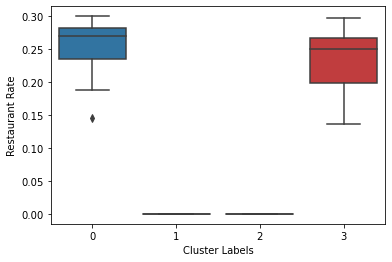

In [34]:
# Understand which cluster has higher Restaurant Rate
ax = sns.boxplot(x="Cluster Labels", y="Restaurant Rate", data=slc_all)

From the box plot above, we can see cluster 0 / 3 have much higher restaurant rate. 

In [35]:
# all restaurant type columns
slc_all.columns[14:46]

Index(['African Restaurant', 'American Restaurant', 'Asian Restaurant',
       'Belgian Restaurant', 'Brazilian Restaurant', 'Chinese Restaurant',
       'Dim Sum Restaurant', 'Ethiopian Restaurant', 'Fast Food Restaurant',
       'German Restaurant', 'Gluten-free Restaurant', 'Greek Restaurant',
       'Himalayan Restaurant', 'Indian Restaurant', 'Italian Restaurant',
       'Japanese Restaurant', 'Korean Restaurant', 'Latin American Restaurant',
       'Mediterranean Restaurant', 'Mexican Restaurant',
       'Middle Eastern Restaurant', 'New American Restaurant',
       'Ramen Restaurant', 'Restaurant', 'Scandinavian Restaurant',
       'Seafood Restaurant', 'Spanish Restaurant', 'Sushi Restaurant',
       'Taiwanese Restaurant', 'Thai Restaurant',
       'Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant'],
      dtype='object')

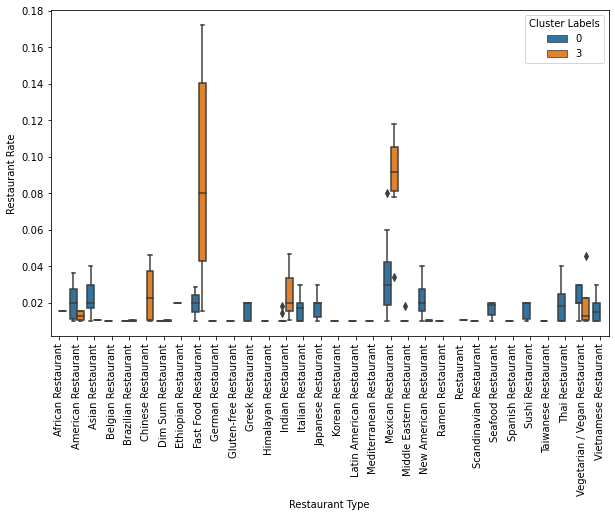

In [36]:
slc_r = pd.melt(slc_all,id_vars=["Cluster Labels"], value_vars=slc_all.columns[14:46])
slc_r = slc_r.rename(columns={"variable":"Restaurant Type","value":"Restaurant Rate"})

slc_r.drop(slc_r[(slc_r['Cluster Labels'] == "1") | (slc_r['Cluster Labels'] == '2')].index, inplace = True)
slc_r.drop(slc_r[slc_r['Restaurant Rate'] < 0.001].index,inplace=True)
# Plot the restaurant rate by restaurant type
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
ax = sns.boxplot(x="Restaurant Type", y="Restaurant Rate", hue = "Cluster Labels", data=slc_r)

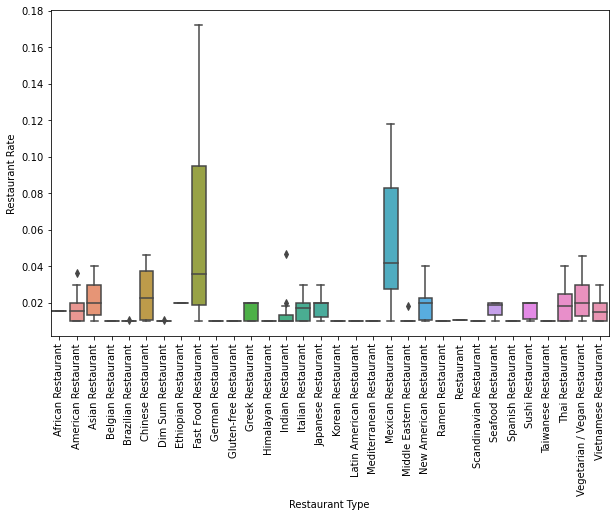

In [56]:
# Plot the restaurant rate by restaurant type, but not separating by cluster
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
ax = sns.boxplot(x="Restaurant Type", y="Restaurant Rate", data=slc_r)

From the plot above, we can have several observations:  
1. Fast Food and Mexican restaurants are more popular than other types, especially in Cluster 3 neighborhoods.  
2. Also observed cluster 0 neighborhoods tend to have more types of restaurant
3. Overall, top restaurant types are Fast Food, Mexican, Chinese, Asian, Vegan, Thai

#### Step 2.3: Examine if demographic factors show significant difference among clusters.

In [37]:
# all demographic factor columns
slc_all.columns[47:69]

Index(['Population', 'Household Count', 'Age Senior Percentage',
       'Age Old Adult Percentage', 'Age Young Adult Percentage',
       'Age College Percentage', 'Age Children Percentage',
       'Race White Percentage', 'Race Hispanic Percentage',
       'Race Black Percentage', 'Race Asian Percentage',
       'Race Mixed Percentage', 'Race Other Percentage',
       'Household Married Percentage', 'Income 80percentile',
       'Income 60percentile', 'Income 50percentile', 'Income 40percentile',
       'Income 20percentile', 'Education High Degree Percentage',
       'Education High School Percentage',
       'Education No High School Percentage'],
      dtype='object')

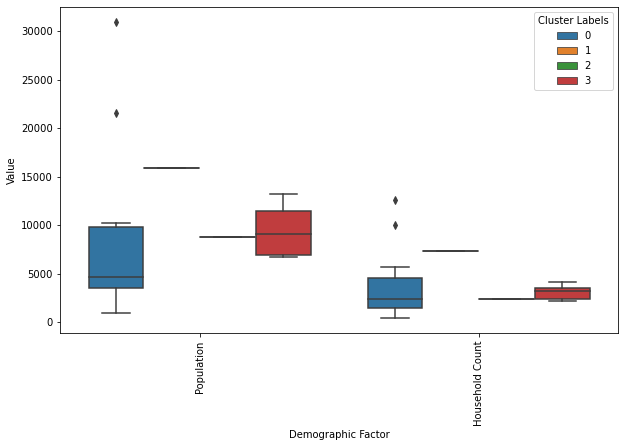

In [38]:
# create lists for factors that have similar value range
list1 = ['Population', 'Household Count']
list2 = ['Income 80percentile',
       'Income 60percentile', 'Income 50percentile', 'Income 40percentile',
       'Income 20percentile']
list3 = ['Age Senior Percentage',
       'Age Old Adult Percentage', 'Age Young Adult Percentage',
       'Age College Percentage', 'Age Children Percentage',
       'Race White Percentage', 'Race Hispanic Percentage',
       'Race Black Percentage', 'Race Asian Percentage',
       'Race Mixed Percentage', 'Race Other Percentage',
       'Household Married Percentage','Education High Degree Percentage',
       'Education High School Percentage',
       'Education No High School Percentage']
slc_d1 = pd.melt(slc_all,id_vars=["Cluster Labels"], value_vars=list1)
slc_d1 = slc_d1.rename(columns={"variable":"Demographic Factor","value":"Value"})
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
ax = sns.boxplot(x="Demographic Factor", y="Value", hue = "Cluster Labels", data=slc_d1)

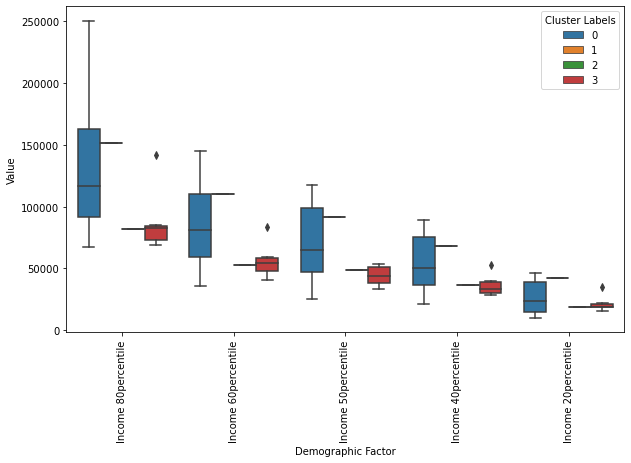

In [39]:
slc_d2 = pd.melt(slc_all,id_vars=["Cluster Labels"], value_vars=list2)
slc_d2 = slc_d2.rename(columns={"variable":"Demographic Factor","value":"Value"})
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
ax = sns.boxplot(x="Demographic Factor", y="Value", hue = "Cluster Labels", data=slc_d2)

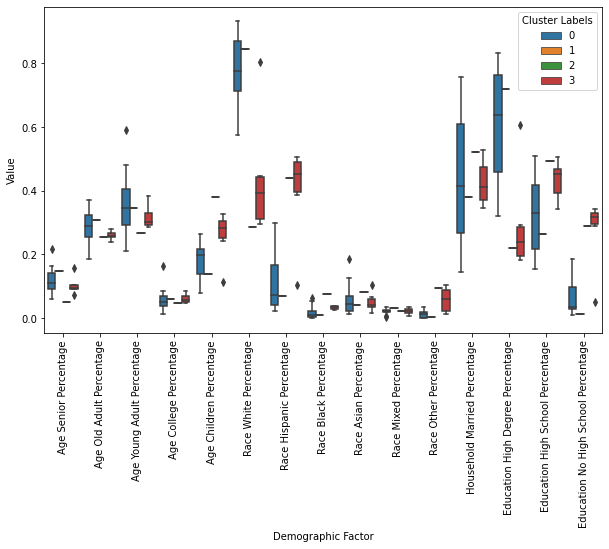

In [40]:
slc_d3 = pd.melt(slc_all,id_vars=["Cluster Labels"], value_vars=list3)
slc_d3 = slc_d3.rename(columns={"variable":"Demographic Factor","value":"Value"})
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
ax = sns.boxplot(x="Demographic Factor", y="Value", hue = "Cluster Labels", data=slc_d3)

From the above plots, cluster 0 and 3 have similar population and household counts. But cluster 0 neighborhoods appear to have higher income, higher adult percentage, higher white race percentage, higher high degree percentage.

#### Step 2.4: Examine if a model can be created to explain the restaurant percentage in each neighborhood. If so, then find which neighborhoods have less restaurant than model predicted. Such neighborhoods can be an opportunity to open new restaurants.

In [41]:
# Based on the above plots (understanding of demographic factors that show difference between clusters), pick the demographic factors to build a model for restaurant rate
# pick the factors
factor_list = ['Income 80percentile',
               'Income 60percentile', 'Income 50percentile',
                'Age Senior Percentage',
               'Age Old Adult Percentage', 'Age Young Adult Percentage',
              'Race White Percentage','Education High Degree Percentage']

# drop cluster 1 and 2 from the dataset
slc_model = slc_all.drop(slc_all[(slc_all['Cluster Labels'] == '1') | (slc_all['Cluster Labels'] == '2')].index)
slc_model
                                

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,African Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Chinese Restaurant,Dim Sum Restaurant,Ethiopian Restaurant,Fast Food Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Himalayan Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Ramen Restaurant,Restaurant,Scandinavian Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Restaurant Rate,Population,Household Count,Age Senior Percentage,Age Old Adult Percentage,Age Young Adult Percentage,Age College Percentage,Age Children Percentage,Race White Percentage,Race Hispanic Percentage,Race Black Percentage,Race Asian Percentage,Race Mixed Percentage,Race Other Percentage,Household Married Percentage,Income 80percentile,Income 60percentile,Income 50percentile,Income 40percentile,Income 20percentile,Education High Degree Percentage,Education High School Percentage,Education No High School Percentage
0,Arcadia Heights,40.724061,-111.814266,0,Pizza Place,Video Store,Mexican Restaurant,Zoo Exhibit,Sporting Goods Shop,Bank,Burger Joint,Coffee Shop,Convenience Store,Fast Food Restaurant,0.000000,0.014493,0.014493,0.00,0.000000,0.000000,0.000000,0.00,0.028986,0.00,0.00,0.00,0.00,0.014493,0.014493,0.014493,0.00,0.00,0.00,0.043478,0.000000,0.014493,0.00,0.000000,0.00,0.014493,0.00,0.014493,0.00,0.000000,0.000000,0.00,0.188406,930,359,0.2170,0.330,0.261,0.0126,0.1790,0.864,0.0305,0.0000,0.0798,0.0252,0.0000,0.7577,250000.0,145200.0,98900.0,88900.0,46100.0,0.833,0.153,0.0134
1,Bonneville Hills,40.736822,-111.832721,0,Coffee Shop,Video Store,Pizza Place,Shipping Store,Sandwich Place,Mexican Restaurant,Ice Cream Shop,Seafood Restaurant,Salon / Barbershop,Park,0.000000,0.020000,0.000000,0.01,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.010000,0.000000,0.020000,0.00,0.00,0.01,0.030000,0.010000,0.020000,0.00,0.000000,0.01,0.020000,0.00,0.010000,0.00,0.010000,0.000000,0.01,0.190000,3840,1314,0.1450,0.321,0.251,0.0490,0.2340,0.896,0.0411,0.0047,0.0528,0.0052,0.0000,0.6469,184500.0,122800.0,100200.0,77000.0,36900.0,0.759,0.231,0.0101
2,Capitol Hill,40.795715,-111.914489,3,Mexican Restaurant,Pizza Place,Convenience Store,Park,Grocery Store,Chinese Restaurant,Discount Store,Coffee Shop,Gas Station,Train Station,0.000000,0.015385,0.000000,0.00,0.000000,0.046154,0.000000,0.00,0.015385,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.092308,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.015385,0.00,0.184615,7254,3385,0.1580,0.261,0.382,0.0844,0.1140,0.804,0.1040,0.0259,0.0382,0.0161,0.0121,0.3465,141800.0,83200.0,53300.0,52700.0,35100.0,0.608,0.342,0.0495
3,Central City,40.755205,-111.884654,0,Coffee Shop,Bar,Bakery,New American Restaurant,Brewery,Grocery Store,Italian Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Burger Joint,0.000000,0.000000,0.030000,0.00,0.010000,0.000000,0.010000,0.00,0.000000,0.01,0.00,0.02,0.01,0.010000,0.030000,0.010000,0.00,0.00,0.01,0.010000,0.010000,0.040000,0.00,0.000000,0.00,0.020000,0.00,0.020000,0.00,0.010000,0.030000,0.01,0.300000,9633,5649,0.1200,0.240,0.480,0.0662,0.0932,0.682,0.1600,0.0530,0.0487,0.0199,0.0355,0.1457,67500.0,40200.0,33100.0,24300.0,12900.0,0.465,0.440,0.0942
4,Central City-Liberty Wells,40.742818,-111.883353,0,Coffee Shop,Bakery,Bar,Asian Restaurant,Cocktail Bar,Vietnamese Restaurant,Brewery,Vegetarian / Vegan Restaurant,Juice Bar,New American Restaurant,0.000000,0.010000,0.040000,0.00,0.010000,0.000000,0.0

In [42]:
# create a multivariate linear regression model for each restaurant type and ovarall restaurant rate
r_list = slc_model.columns[14:47]

In [63]:
# iterate through the list of restaurants and do fit model for each row
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(slc_model[factor_list])
score_list = []

for row in r_list:
    y = np.asanyarray(slc_model[[row]])
    regr.fit (x, y)

    score_list.append(regr.score(x,y))



In [52]:
r_list

Index(['African Restaurant', 'American Restaurant', 'Asian Restaurant',
       'Belgian Restaurant', 'Brazilian Restaurant', 'Chinese Restaurant',
       'Dim Sum Restaurant', 'Ethiopian Restaurant', 'Fast Food Restaurant',
       'German Restaurant', 'Gluten-free Restaurant', 'Greek Restaurant',
       'Himalayan Restaurant', 'Indian Restaurant', 'Italian Restaurant',
       'Japanese Restaurant', 'Korean Restaurant', 'Latin American Restaurant',
       'Mediterranean Restaurant', 'Mexican Restaurant',
       'Middle Eastern Restaurant', 'New American Restaurant',
       'Ramen Restaurant', 'Restaurant', 'Scandinavian Restaurant',
       'Seafood Restaurant', 'Spanish Restaurant', 'Sushi Restaurant',
       'Taiwanese Restaurant', 'Thai Restaurant',
       'Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant',
       'Restaurant Rate'],
      dtype='object')

In [64]:
fit_score = pd.DataFrame({"Restaurant":r_list, "Fit Score":score_list})
fit_score

,Restaurant,Fit Score
0,African Restaurant,0.326475
1,American Restaurant,0.637694
2,Asian Restaurant,0.426773
3,Belgian Restaurant,0.623991
4,Brazilian Restaurant,0.605012
5,Chinese Restaurant,0.266289
6,Dim Sum Restaurant,0.495331
7,Ethiopian Restaurant,0.559323
8,Fast Food Restaurant,0.625155
9,German Restaurant,0.771933


From fit_score, we can see among the popular restaurant types, Thai and Fast food restaurants have relatively higher score (>0.6, which is the score for average restaurant rate)

In [68]:
# Calculate the predicted restaurant rate for Thai and Fast food
y = np.asanyarray(slc_model["Thai Restaurant"])
regr.fit (x, y)
yhat_thai = regr.predict(x)
y = np.asanyarray(slc_model["Fast Food Restaurant"])
regr.fit (x, y)
yhat_ff = regr.predict(x)


In [77]:
# generate a dataframe to compare Thai / fast food actual restaurant rate vs. fit model for each neighborhood
slc_result = pd.DataFrame({
    "Neighborhood":slc_model["Neighborhood"],
    "Thai Restaurant Actual": slc_model["Thai Restaurant"],
    "Thai Restaurant Predicted":yhat_thai,
    "Fast Food Restaurant Actual": slc_model["Fast Food Restaurant"],
    "Fast Food Restaurant Predicted": yhat_ff
})
slc_result["Thai Predicted - Actual"] = slc_result["Thai Restaurant Predicted"] - slc_result["Thai Restaurant Actual"]
slc_result["Fast Food Predicted - Actual"] = slc_result["Fast Food Restaurant Predicted"] - slc_result["Fast Food Restaurant Actual"]

In [78]:
slc_result

,Neighborhood,Thai Restaurant Actual,Thai Restaurant Predicted,Fast Food Restaurant Actual,Fast Food Restaurant Predicted,Thai Predicted - Actual,Fast Food Predicted - Actual
0,Arcadia Heights,0.000000,-0.005528,0.028986,0.038636,-0.005528,0.009651
1,Bonneville Hills,0.010000,0.008553,0.000000,0.002135,-0.001447,0.002135
2,Capitol Hill,0.000000,0.008515,0.015385,0.004326,0.008515,-0.011058
3,Central City,0.010000,0.021955,0.000000,0.002097,0.011955,0.002097
4,Central City-Liberty Wells,0.020000,0.018675,0.000000,0.011331,-0.001325,0.011331
5,Downtown,0.010000,0.000884,0.010000,0.016775,-0.009116,0.006775
6,East Bench,0.018182,0.014171,0.000000,0.002845,-0.004011,0.002845
7,East Central,0.010000,0.017578,0.000000,-0.009592,0.007578,-0.009592
8,Fairpark,0.000000,0.001715,0.043011,0.075705,0.001715,0.032694
9,Glendale,0.000000,0.000012,0.140625,0.085555,0.000012,-0.055070


From slc_result table, higher positive "predicted - actual" column suggests the model predicts a higher restaurant rate than actual, which may suggest an opportunity to open a restaurant there. From this argument, if we would like to open a Thai restaurant, "Central City" (predicted - actual is 0.012) may be a good option. If we would like to open a fast food restaurant, "Rose Park" (predicted - actual is 0.06) may be a good option.